In [16]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import copy
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
import gym
import thinker.util as util
from visual import *
%matplotlib inline

def load_env_model(check_point_path, seed=1):

    checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
    flags = util.parse(['--load_checkpoint', check_point_path])
    #flags.rec_t = 4

    flags_ = copy.deepcopy(flags)
    flags_.actor_see_p = 1
    flags_.actor_see_encode = True
    flags_.actor_see_h = True
    #flags_.max_depth = 5
    env = Environment(flags_, model_wrap=True)

    env.seed([seed])
    num_actions = env.num_actions

    flags_ = copy.deepcopy(flags)
    flags_.perfect_model = True
    flags_.actor_see_p = 1
    #flags_.max_depth = 5  
    perfect_env = Environment(flags_, model_wrap=True)
    perfect_env.seed([seed])

    model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
    model_net.train(False)
    model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                        checkpoint else checkpoint["model_net_state_dict"])  

    env_out = env.initial(model_net)
    perfect_env_out = perfect_env.initial(model_net)

    util.decode_model_out(env_out.model_out, num_actions, True)    
    #plot_gym_env_out(env_out.gym_env_out.squeeze(0))
    #_ = decode(model_net, env_out, visualize=True)

    return model_net, env, perfect_env, env_out, perfect_env_out, flags

def step_reals(actions, env, perfect_env, model_net, flags):
    for a in actions:
        while(True):
            action = torch.tensor([[[a, 0, 0]]], dtype=torch.long)    
            env_out = env.step(action, model_net)            
            perfect_env_out = perfect_env.step(action, model_net)                    
            sp = torch.sum(torch.abs(env_out.model_encodes) < 1e-4)/(torch.numel(env_out.model_encodes))
            if env_out.cur_t[0,0] == 0: break
    return env_out, perfect_env_out, sp

def tb_out(model_net_out):
    d = {}
    for k in model_net_out._fields:
        if type(getattr(model_net_out,k)) == torch.Tensor:
            d[k] = getattr(model_net_out,k).squeeze(0).unsqueeze(1)
    return util.construct_tuple(type(model_net_out), **d)   


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


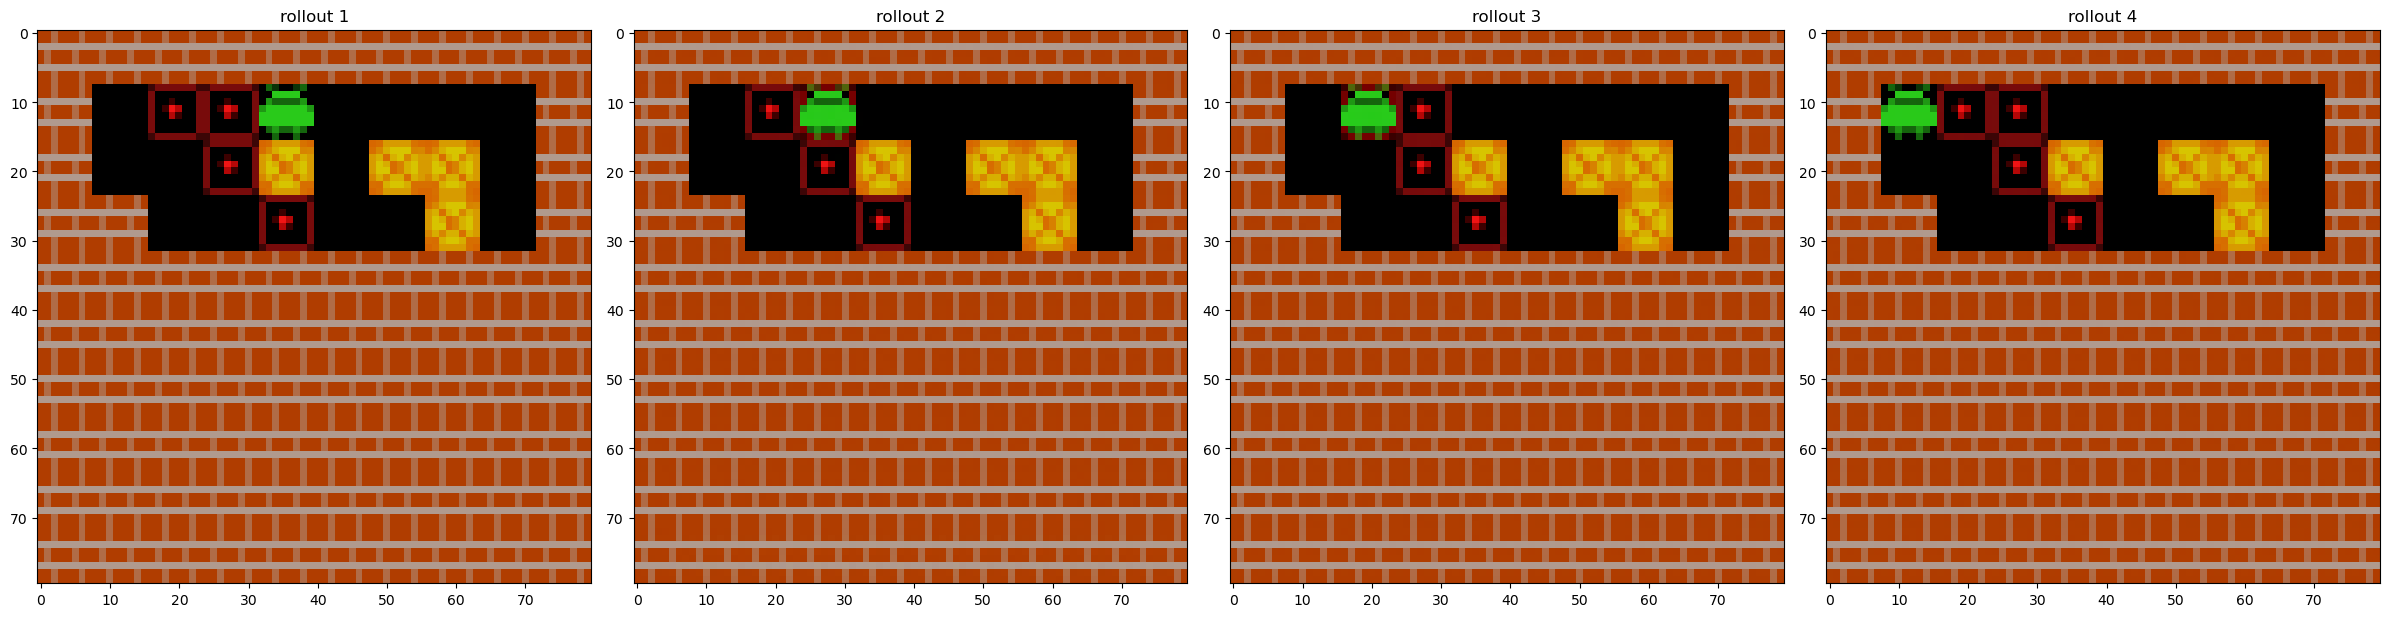

In [12]:
check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_duel_net_100_imgc_done_g/'
model_net, env, perfect_env, env_out, perfect_env_out, flags = load_env_model(check_point_path, seed=1)

#actions = np.random.randint(low=0, high=5, size=(6))
actions = [3,3,3,3,]
actions = torch.tensor(actions).unsqueeze(-1)
model_net_out = model_net(env_out.gym_env_out, actions=actions, one_hot=False, compute_true_z=False, inference=True)
pred_xs = torch.concat([env_out.gym_env_out[[0]].float()/255., model_net_out.pred_xs], dim=0)
plot_env_outs = np.clip(pred_xs[:,0].detach().cpu().numpy()*255,0,255)
_ = plot_multi_gym_env_out(plot_env_outs, titles=None, col_n=4)

step: 0; z_diff 0.000000, im reward: 0.000000 (p: 0.000000) root_v: 10.926613 (p: 10.926613) max_v: 10.926613 (p: 10.926613)trail_q:10.926613 (p: 10.926613) max_q: -0.000000 (p: -0.000000) mean_q: 0.000000 (p: 0.000000) sparsity: 0.400937
done:  (tensor([False]), tensor([-26.5466]))
step: 1; z_diff 0.018519, im reward: 0.000000 (p: 0.000000) root_v: 10.926613 (p: 10.926613) max_v: 10.926613 (p: 10.926613)trail_q:9.990618 (p: 9.944034) max_q: 9.990618 (p: 9.944034) mean_q: 1.998124 (p: 1.988807) sparsity: 0.503750
done:  (tensor([False]), tensor([-26.2378]))
step: 2; z_diff 0.001173, im reward: 0.000000 (p: 0.000000) root_v: 10.926613 (p: 10.926613) max_v: 10.926613 (p: 10.926613)trail_q:10.076545 (p: 10.072974) max_q: 10.076545 (p: 10.072974) mean_q: 2.006668 (p: 2.001682) sparsity: 0.505625
done:  (tensor([False]), tensor([-25.3841]))
step: 3; z_diff 0.002927, im reward: 0.000000 (p: 0.000000) root_v: 10.926613 (p: 10.926613) max_v: 10.926613 (p: 10.926613)trail_q:9.791162 (p: 9.74930

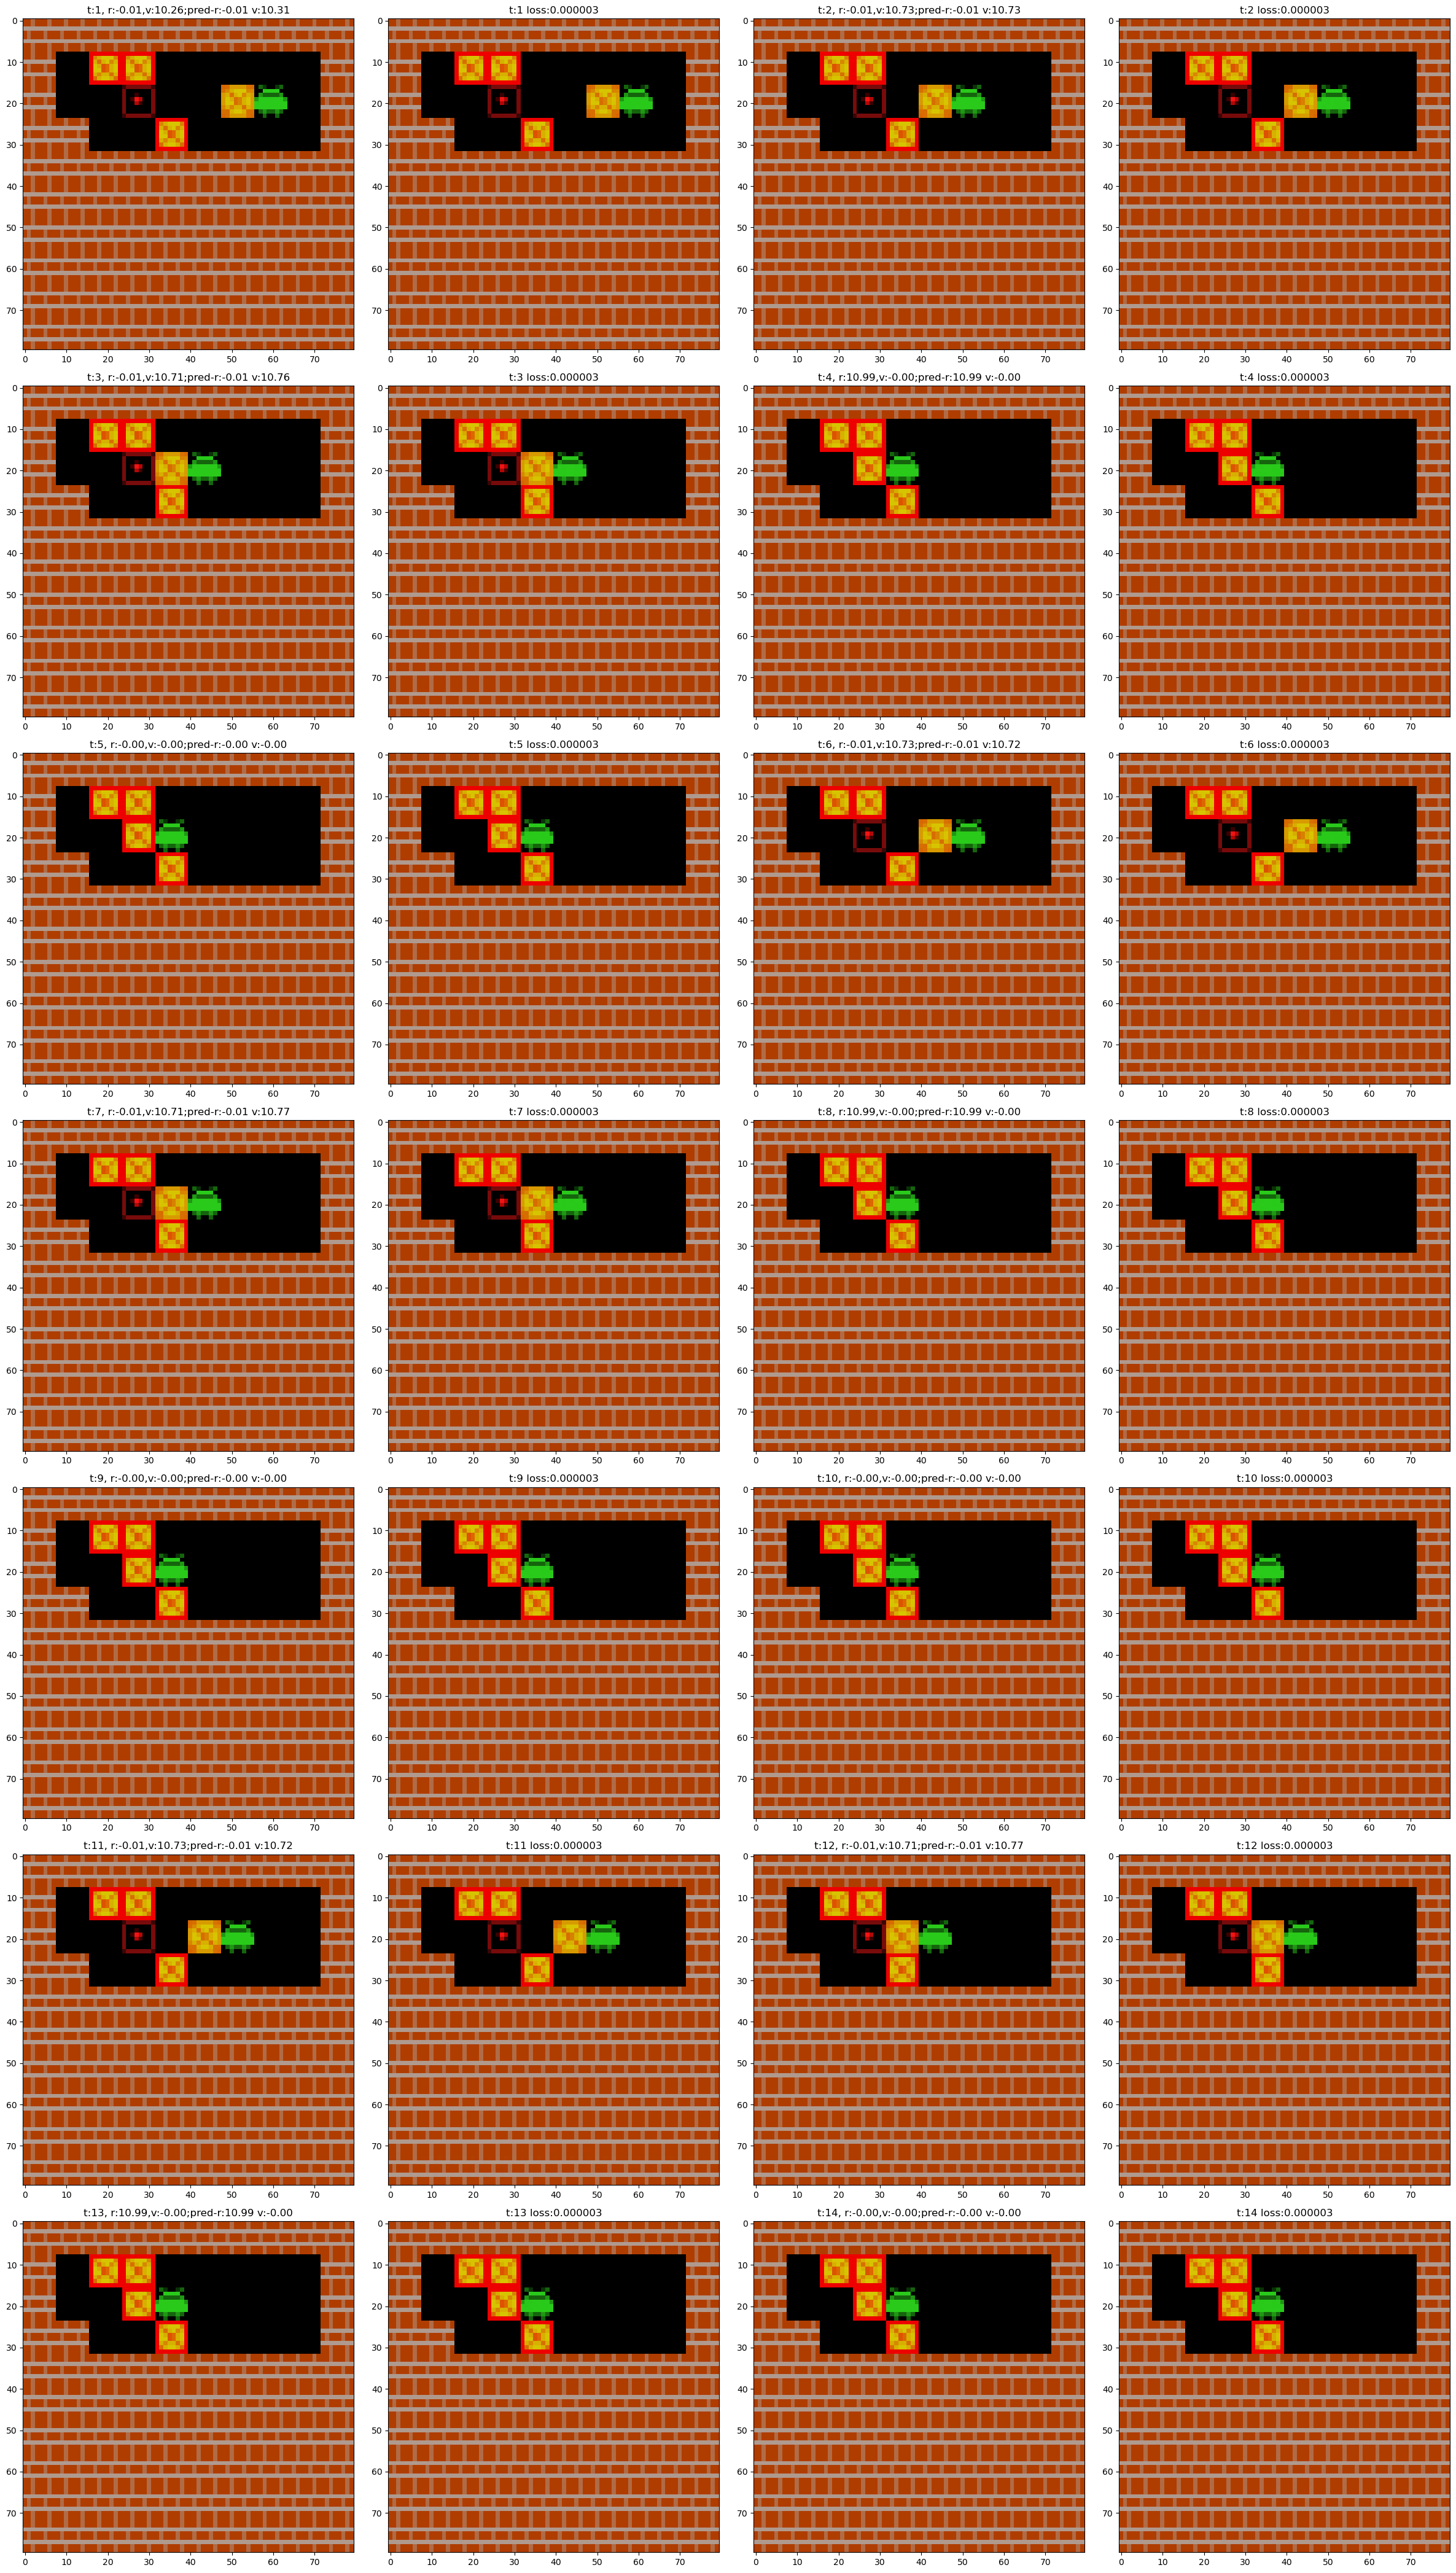

In [20]:
# See what the model learns

#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/value_prefix/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_8'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_l2_loss_sep_zh_d'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_img_loss_0.01'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_cos_loss_sep_zh_b'
check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_duel_net_100_imgc_done_g'
check_point_path = os.path.expanduser(check_point_path)
model_net, env, perfect_env, env_out, perfect_env_out, flags = load_env_model(check_point_path)
num_actions = env.num_actions

actions = [4,2,3,3,2,3,1,4,4,4,4,1,4,4,4,2,2,3,3,3,4,1,2,2,4,4,4,1,1,3,3,3,3,3,3,4,4,4,4,4,4,4,4,2,3]
env_out, perfect_env_out, sp = step_reals(actions, env, perfect_env, model_net, flags)

#im_actions = [2 for _ in range(20)]
im_actions = [4, 2, 3]
im_actions = [3,3,3,3,3,3,3,3,3,3,3,3,3]
model_outs, perfect_model_outs = {}, {}
gym_env_outs = []
rec_env_outs = []

def print_info(n, env_out, perfect_env_out, num_actions):
    model_out = util.decode_model_out(env_out.model_out, num_actions, True)
    perfect_model_out = util.decode_model_out(perfect_env_out.model_out, num_actions, True)
    sp = torch.sum(torch.abs(env_out.model_encodes) < 1e-4)/(torch.numel(env_out.model_encodes))
    #z_diff = torch.mean(torch.square(env_out.model_encodes - perfect_env_out.model_encodes))
    z_diff = torch.mean(torch.square(model_out["raw"] - perfect_model_out["raw"]))
    #z_diff = 0.
    print(("step: %d; z_diff %f, im reward: %f (p: %f) root_v: %f (p: %f) max_v: %f (p: %f)" +
          "trail_q:%f (p: %f) max_q: %f (p: %f) mean_q: %f (p: %f) sparsity: %f") % (
        n, z_diff,
        env_out.reward[0,0,1], perfect_env_out.reward[0,0,1], 
        model_out["root_v"], perfect_model_out["root_v"],
        model_out["root_max_v"], perfect_model_out["root_max_v"],
        model_out["root_trail_q"], perfect_model_out["root_trail_q"],
        torch.max(model_out["root_qs_max"]), torch.max(perfect_model_out["root_qs_max"]),
        torch.mean(model_out["root_qs_mean"]), torch.mean(perfect_model_out["root_qs_mean"]), sp))

def decode(model_net, env_out, visualize):
    model_encodes = env_out.model_encodes
    if model_net.flags.duel_net:
        model_encodes = model_encodes.squeeze(0)
        k = model_net.sep_h_idx
        model_h = model_encodes[:,k:2*k]
        rec_env_out = model_net.modelEncoder.decode(model_h)   
    elif model_net.frameEncoder.decoder:            
        if len(model_encodes.shape) == 5: model_encodes = model_encodes.squeeze(0)
        if model_net.type_nn in [0, 1, 2, 3]:
            rec_env_out = model_net.frameEncoder.decode(model_encodes)
        else:
            rec_env_out = model_net.frameEncoder.decode(model_encodes[0,:,:-512], h=model_encodes[0,:,-512:])
    else:
        return None
    rec_env_out = rec_env_out.squeeze(0).detach()
    rec_env_out = (torch.clip(rec_env_out, 0, 1) * 255).int()
    if visualize: plot_gym_env_out(rec_env_out.unsqueeze(0))
    return rec_env_out

print_info(0, env_out, perfect_env_out, num_actions)
for n, im_action in enumerate(im_actions):
    action = torch.tensor([[[0, im_action, 0]]], dtype=torch.long)
    env_out = env.step(action, model_net)    
    model_out = util.decode_model_out(env_out.model_out, num_actions, True)        
    perfect_env_out = perfect_env.step(action, model_net)          
    perfect_model_out = util.decode_model_out(perfect_env_out.model_out, num_actions, True)  

    gym_env_outs.append(perfect_env_out.gym_env_out.squeeze(0).squeeze(0))
    rec_env_out = decode(model_net, env_out, visualize=False)
    if rec_env_out is not None: rec_env_outs.append(rec_env_out)

    #pred_encodes = model_net.frameEncoder(rec_env_out.unsqueeze(0), F.one_hot(action[0, :, 1], num_classes=5))[0]
    #z_diff = torch.mean(torch.abs(pred_encodes - perfect_env_out.model_encodes))
    #print(z_diff)

    print_info(n+1, env_out, perfect_env_out, num_actions)
    #assert torch.all(model_out["root_logits"] == perfect_model_out["root_logits"])

    for outs, out in [[model_outs, model_out], [perfect_model_outs, perfect_model_out]]:
        for k, v in out.items():
            if k not in outs:
                outs[k] = [v]
            else:
                outs[k].append(v)
    
titles = []
plot_env_outs = []
for n in range(len(model_outs["cur_r"])):
    titles.append("t:%d, r:%.2f,v:%.2f;pred-r:%.2f v:%.2f" % (
        n+1, perfect_model_outs["cur_r"][n],
        perfect_model_outs["cur_v"][n], model_outs["cur_r"][n], model_outs["cur_v"][n]))
    plot_env_outs.append(gym_env_outs[n])
    if len(rec_env_outs) > 0:
        l2_loss = torch.mean(torch.square((rec_env_outs[n]-gym_env_outs[n]).float()/255.))
        titles.append("t:%d loss:%f" % (n+1,l2_loss))
        plot_env_outs.append(rec_env_outs[n])
    

fig = plot_multi_gym_env_out(plot_env_outs, titles=titles, col_n=4)
plt.show()


In [ ]:
flags = util.parse(['--load_checkpoint', check_point_path])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
xs = [env_out.gym_env_out]
actions = [0,1,1,2,2]
for a in actions[1:]:
    a = torch.tensor(a, dtype=torch.long).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    env_out = env.step(a)
    xs.append(env_out.gym_env_out)

xs = torch.concat(xs, dim=0)
actions = torch.tensor(actions, dtype=torch.long).unsqueeze(-1)
model_net_out = model_net(xs, 
                          actions=actions, 
                          compute_true_z=True, 
                          one_hot=False, 
                          inference=False)
print("zs L2 error: %f" % torch.mean(torch.square(model_net_out.true_zs[1:] - model_net_out.pred_zs[1:])))

perfect_model_net_out = tb_out(model_net(xs.flatten(0,1).unsqueeze(0), 
                               actions.flatten(0,1).unsqueeze(0), one_hot=False))
     
print("zs L2 error: %f" % torch.mean(torch.square(perfect_model_net_out.true_zs[1:] - model_net_out.pred_zs[1:])))
print("logit error: %f" % torch.mean(torch.square(perfect_model_net_out.logits - model_net_out.logits)))
print("v error: %f" % torch.mean(torch.square(perfect_model_net_out.vs - model_net_out.vs)))

In [ ]:
# Visualize learned actor network

#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_10'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v4/v4_large_tran'
check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_5_depth_2'
#check_point_path = '~/RS/thinker/logs/thinker/latest'

check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 1
visualize = True
saveimg = False
saveimg_dir = "/home/sc/RS/thinker/test/data/"

flags = util.parse(['--load_checkpoint', check_point_path])
name = "%s-%s"%(flags.xpid, time.strftime("%Y%m%d-%H%M%S"))

if saveimg:
    saveimg_a = os.path.join(saveimg_dir, name, "a")
    saveimg_b = os.path.join(saveimg_dir, name, "b")
    if not (os.path.exists(saveimg_a)): os.makedirs(saveimg_a)
    if not (os.path.exists(saveimg_b)): os.makedirs(saveimg_b)
    print("saving images to %s" % (os.path.join(saveimg_dir, name)))
    savef = open(os.path.join(saveimg_dir, name, "logs.txt"), 'a')

env = Environment(flags, model_wrap=True)
if not flags.perfect_model: 
    flags_ = copy.deepcopy(flags)
    flags_.perfect_model = True
    flags_.actor_see_p = 1
    perfect_env = Environment(flags_, model_wrap=True)

if flags.env == "cSokoban-v0" or flags.env == "Sokoban-v0":
    action_meanings = ["NOOP", "UP", "DOWN", "LEFT", "RIGHT"]
else:
    action_meanings = gym.make(flags.env).get_action_meanings()
num_actions = env.num_actions

seed = 3
env.seed([seed])
if not flags.perfect_model: perfect_env.seed([seed])

model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
#checkpoint = torch.load(os.path.join('/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_8','ckp_model.tar'), torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  

actor_net = ActorNet(obs_shape=env.model_out_shape, gym_obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_actor.tar'), torch.device("cpu"))         
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1) 

env_out = env.initial(model_net)
if not flags.perfect_model: 
    perfect_env_out = perfect_env.initial(model_net)
    assert torch.all(env_out.gym_env_out == perfect_env_out.gym_env_out)

gym_env_out_ = env_out.gym_env_out
model_out = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
end_gym_env_outs, end_titles = [], []

step = 0
returns, model_logits, attn_output = [], [], [], 
im_list = ["im_policy_logits", "reset_policy_logits", "im_action", "reset_action"]
im_dict = {k: [] for k in im_list}

video_stats = {"real_imgs": [], "im_imgs":[], "status":[]}
video_stats["real_imgs"].append(env_out.gym_env_out[0,0,-3:].numpy())
video_stats["im_imgs"].append(video_stats["real_imgs"][-1])
video_stats["status"].append(0) # 0 for real step, 1 for reset, 2 for normal

if not visualize: plt.ioff()

while len(returns) < max_eps_n:    
    step += 1
    actor_out, actor_state = actor_net(env_out, actor_state)      

    if env_out.cur_t[0,0] == 0: agent_v = actor_out.baseline[0,0,0]
    action = [actor_out.action, actor_out.im_action, actor_out.reset_action]
    action = torch.cat(action, dim=-1).unsqueeze(0)

    # additional stat record    
    for k in im_list: 
        im_dict[k].append(getattr(actor_out, k)[:, 0] if k in actor_out._fields and 
            getattr(actor_out, k) is not None else None)        
    #attn_output.append(torch.cat([x.attn_output_weights.unsqueeze(0).unsqueeze(-2) for x in actor_net.core.layers])[:, :, 0, :])        

    model_out_ = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
    model_logits.append(model_out_["cur_logits"])
    env_out  = env.step(action, model_net)
    model_out = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
    if len(im_dict['reset_action']) > 0: im_dict['reset_action'][-1] = model_out["reset"]
    if not flags.perfect_model: perfect_env_out  = perfect_env.step(action, model_net)    
    gym_env_out = env_out.gym_env_out if flags.perfect_model else perfect_env_out.gym_env_out
    if not flags.perfect_model:
        perfect_model_out = util.decode_model_out(perfect_env_out.model_out, num_actions, flags.reward_transform)

    if model_out["reset"] == 1 or env_out.cur_t[0,0] == flags.rec_t-1:   
        title = "pred v: %.2f" % (model_out["cur_v"].item())
        if not flags.perfect_model:
            title += " v: %.2f" % (perfect_model_out["cur_v"].item())
        end_gym_env_outs.append(gym_env_out[0,0].numpy())
        end_titles.append(title)

    if not flags.perfect_model and env_out.cur_t[0,0] == 0:
        assert torch.all(env_out.gym_env_out == perfect_env_out.gym_env_out)    

    # record data for generating video
    if action[0,0,2] == 1:
        video_stats["real_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["im_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["status"].append(1)

    if env_out.cur_t[0,0] == 0:
        video_stats["real_imgs"].append(gym_env_out[0,0,-3:].numpy())
        video_stats["status"].append(0)
    else:
        video_stats["real_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["status"].append(2)
    video_stats["im_imgs"].append(gym_env_out[0,0,-3:].numpy())    

    # visualize when a real step is made
    if (saveimg or visualize) and env_out.cur_t[0,0] == 0:
        fig, axs = plt.subplots(1, 5, figsize=(30,6))      
        title = "%d; v: %.2f (%.2f)" % (step, model_out_["root_v"][0], agent_v)
        title += " max_q: %.2f mean_q_0: %.2f" % (env.env.baseline_max_q[0], env.env.baseline_mean_q[0])
        for k in im_list: 
            if im_dict[k][0] is not None:
                im_dict[k] = torch.concat(im_dict[k], dim=0)            
            else:
                im_dict[k] = None        
        
        if flags.reward_type == 1: title += " im_return: %.4f" % env_out.episode_return[..., 1]                        
        plot_gym_env_out(gym_env_out_[0], axs[0], title=title)  
        plot_base_policies(torch.concat(model_logits), action_meanings=action_meanings, ax=axs[1])  
        plot_im_policies(**im_dict, action_meanings=action_meanings, one_hot=False, reset_ind=1, ax=axs[2])   

        mean_q_s_a = model_out_["root_qs_mean"][0]
        max_q_s_a = model_out_["root_qs_max"][0]
        n_s_a = model_out_["root_ns"][0]
        plot_qn_sa(mean_q_s_a, n_s_a, action_meanings=action_meanings, max_q_s_a=max_q_s_a, ax=axs[3]) 

        model_policy_logits = model_out_["root_logits"][0]
        agent_policy_logits = actor_out.policy_logits[0,0]
        action = torch.nn.functional.one_hot(actor_out.action[0,0], env.num_actions)
        plot_policies([model_policy_logits, agent_policy_logits, action], 
            ["model policy", "agent policy", "action"], action_meanings=action_meanings, ax=axs[4])  
        
        if saveimg: plt.savefig(os.path.join(saveimg_a,"%d.png" %step))
        if visualize: plt.show()        
        plt.close()

        fig = plot_multi_gym_env_out(end_gym_env_outs, end_titles)        
        if saveimg: plt.savefig(os.path.join(saveimg_b,"%d.png" %step))
        if visualize: plt.show()
        plt.close()

        log_str = "step:%d; return %.4f(%.4f) done %s real_done %s" % (
            step, env_out.episode_return[0,0,0], env_out.episode_return[0,0,1],
            "True" if env_out.done[0,0] else "False", 
            "True" if env_out.real_done[0,0] else "False",)
        print(log_str)
        im_action_strs = print_im_actions(im_dict, action_meanings, print_stat=visualize)           
        if saveimg:
            for s in im_action_strs: savef.write(s+"\n")            
            savef.write(log_str+"\n") 

        gym_env_out_ = gym_env_out
        im_dict = {k: [] for k in im_list}
        model_logits, attn_output, end_gym_env_outs, end_titles = [], [], [], []

    if torch.any(env_out.real_done):
        step = 0
        new_rets = env_out.episode_return[env_out.real_done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  
        
savef.close()        

# Generate video
import cv2

file_path = "/home/sc/RS/thinker/test/v2_supervise_8-20230301-180711.mp4"
imgs = []
hw = video_stats["real_imgs"][0].shape[1]

for i in range(len(video_stats["real_imgs"])):
    img = np.zeros(shape=(hw,hw*2,3),dtype=np.uint8)
    real_img = np.copy(video_stats["real_imgs"][i])
    real_img = np.swapaxes(np.swapaxes(real_img, 0, 2),0, 1)
    im_img = np.copy(video_stats["im_imgs"][i])
    im_img = np.swapaxes(np.swapaxes(im_img, 0, 2),0, 1)
    if video_stats["status"][i] == 1: 
        im_img[:, :, 0] = 255 * 0.3 + im_img[:, :, 0] * 0.7
        im_img[:, :, 1] = 255 * 0.3 + im_img[:, :, 1] * 0.7
    elif video_stats["status"][i] == 0: 
        im_img[:, :, 2] = 255 * 0.3 + im_img[:, :, 2] * 0.7

    img[:,:hw,:] = real_img
    img[:,hw:,:] = im_img
    img = np.flip(img, 2)
    imgs.append(img)

width = hw*2
hieght = hw
channel = 3
fps = 15
 
video = cv2.VideoWriter(file_path, cv2.VideoWriter_fourcc(*'mp4v'), float(fps), (width, hieght)) 
#video = cv2.VideoWriter('RS/thinker/test.mp4', cv2.VideoWriter_fourcc(*'mp4v'), float(fps), (width, hieght)) 
for img in imgs: video.write(img) 
video.release()    

In [ ]:
# debug; check if perfect model passed to non-perfect env can match perfect env output

import torch.nn as nn
from thinker.net import ModelNetOut

class PefectModel():
    def __init__(self, model_net):
        self.model_net = model_net   
        self.done_a = False     
    
    def __call__(self, xs, actions, one_hot=False, dec_enc=False, compute_true_z=False, inference=True):
        return self.model_net(xs, actions, one_hot, dec_enc, compute_true_z, inference)
    
    def forward_zh(self, z, h, r_state, action, one_hot=True, dec_enc=False):        
        if self.done_a: action = self.action_a
        print("forward_zh called")        
        b = action.shape[0]
        # gym_env should be set to current node before calling
        assert not one_hot        
        state = self.gym_env.clone_state(inds=[i for i in range(b)])
        obs, reward, done, info = self.gym_env.step(action)
        self.gym_env.restore_state(state, inds=[i for i in range(b)])
        obs = torch.tensor(obs)
        reward = torch.tensor(reward)
        done = torch.tensor(done, dtype=bool)
        done_mask = (~done).float()
        model_net_out = self.model_net.forward(xs=obs, actions=action.unsqueeze(0))
        self.model_net_out = ModelNetOut(single_rs=(reward).unsqueeze(0) if not self.done_a else torch.zeros(1, b),
                           rs=(reward).unsqueeze(0) if not self.done_a else torch.zeros(1, b), 
                           r_enc_logits=None, 
                           vs=model_net_out.vs*done_mask, 
                           v_enc_logits=None, 
                           logits=model_net_out.logits, 
                           pred_zs=torch.zeros(1, b),
                           pred_z_logits=None,
                           true_zs=None,
                           true_z_logits=None,
                           hs=torch.zeros(1, b), 
                           r_state=(torch.zeros(b, 1),)
                           )
        return self.model_net_out 
    
seed = 1    
check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_cos_loss_sep_zh_b'
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
flags = util.parse(['--load_checkpoint', check_point_path])

flags_ = copy.deepcopy(flags)
flags_.actor_see_p = 1
flags_.actor_see_encode = True
flags_.model_dec_enc = False
flags_.tree_carry = True
env = Environment(flags_, model_wrap=True)

env.seed([seed])
num_actions = env.num_actions

flags_ = copy.deepcopy(flags)
flags_.perfect_model = True
flags_.actor_see_p = 1
flags_.actor_see_h = False    
flags_.tree_carry = True
perfect_env = Environment(flags_, model_wrap=True)
perfect_env.seed([seed])

model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  
perfect_model_net = PefectModel(model_net)

import gym
from thinker.gym_add.asyn_vector_env import AsyncVectorEnv
from thinker.env import PreWrap
gym_env = AsyncVectorEnv([lambda: PreWrap(gym.make(flags.env), flags.env) for _ in range(1)])
gym_env.seed([seed])
obs = gym_env.reset()
perfect_model_net.gym_env = gym_env

env_out = env.initial(perfect_model_net)
perfect_env_out = perfect_env.initial(model_net)

root_state = gym_env.clone_state(inds=[0])
done_a = False
action_a = None
np.random.seed(0)
for n in range(100000):
    action = torch.tensor([[[np.random.randint(5), np.random.randint(5), np.random.randint(2)]]], dtype=torch.long)

    perfect_model_net.done_a = done_a
    perfect_model_net.action_a = action_a
    env_out = env.step(action, perfect_model_net)
    perfect_env_out = perfect_env.step(action, model_net)
    diff = torch.sum(torch.square(env_out.model_out - perfect_env_out.model_out))
    print("step: %d (%d) diff: %f" % (n+1, env_out.cur_t, diff))
    if diff > 1e-6:
        raise Exception("unmatch")    

    if env_out.cur_t == 0:
        gym_env.restore_state(root_state, inds=[0])
        obs, reward, done, info = gym_env.step(action[0,:,0])
        if done: gym_env.reset(inds=[0])
        root_state = gym_env.clone_state(inds=[0])
        done_a = False
    else:
        if util.decode_model_out(env_out.model_out, num_actions, reward_tran=True)["reset"]:
            gym_env.restore_state(root_state, inds=[0])
            obs = None
            done_a = False
        else:
            if not done_a:
                state_ = gym_env.clone_state(inds=[0])
                obs, reward, done, info = gym_env.step(action[0,:,1])
                if done: gym_env.restore_state(state_, inds=[0])
                done_a = done   
                action_a = action[0,:,1]


In [ ]:
# Visualize plain model policy

check_point_path = '~/RS/thinker/models/test'
check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 100
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net_rnn = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags, rnn=True)
model_net_rnn.train(False)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model_rnn.tar'), torch.device("cpu"))                    
model_net_rnn.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  
state = model_net_rnn.core.init_state(bsz=1)

returns = []
step = 0
while len(returns) < max_eps_n:    
    step += 1
    _, model_rnn_logits, state = model_net_rnn(env_out.gym_env_out, env_out.last_action[:,:,0], env_out.done, state)
    action = torch.multinomial(F.softmax(model_rnn_logits[0], dim=1), num_samples=1).unsqueeze(0)
    env_out = env.step(action) 

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6,3))  
        plot_gym_env_out(env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0]))
        plot_policies(model_rnn_logits[0,0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


In [ ]:
# Visualize plain model policy

model_path = '/media/sc/datadisk/data/thinker/logs/planner_logs/thinker_model_no_pri/ckp_model.tar'
max_eps_n = 10
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  

returns = []
step = 0
while len(returns) < max_eps_n:    
    step += 1
    _, vs, policy_logits, _ = model_net(env_out.gym_env_out[0], env_out.last_action[:,:,0], one_hot=False)                            
    action = torch.multinomial(F.softmax(policy_logits[0], dim=1), num_samples=1).unsqueeze(0)
    env_out = env.step(action) 

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6,3))  
        plot_gym_env_out(env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0]))
        plot_policies(policy_logits[0,0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


<h5>Misc.</h5>

In [ ]:
from collections import namedtuple
import sys

import time
import numpy as np
import argparse
import ray
import torch

from thinker.self_play import SelfPlayWorker
from thinker.learn_actor import ActorLearner
from thinker.buffer import *
import thinker.util as util
from thinker.net import *

flags = util.parse([])
flags.model_batch_size = 2
flags.model_unroll_length = 8
flags.model_k_step_return = 5
flags.actor_parallel_n = 4
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = True
flags.priority_alpha = 5

t = flags.model_unroll_length   
k = flags.model_k_step_return
n = flags.actor_parallel_n  

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),2*c), torch.full((t+k, n, 1),2*c+1))    
    model_buffer.write(data)
    r = model_buffer.read(1.)    
    if r is not None:
        data, weights, abs_flat_inds, ps_step = r
        #print(data.x[:,:,0]) 
        #model_buffer.update_priority(abs_flat_inds, np.zeros(flags.model_batch_size))

print("1 read", data.x[:,:,0], weights)
model_buffer.update_priority(abs_flat_inds, np.array([10, 0]))
data, weights, abs_flat_inds, ps_step = model_buffer.read(1.)   
print("2 read", data.x[:,:,0], weights)